# Insurance Cost Prediction

Using age, sex, bmi, number of children, smoking status, and region to predict cost of insurance

dataset: https://www.kaggle.com/datasets/adsamardeep/insurance-and-medical-cost/data

In [76]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

file_path = './insurance.csv'
df = pd.read_csv(file_path)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Exploratory Data Analysis

The dataset has both cateogorical and numerical data. To visualize the data, the numerical and cateogorical features are separated as categorical features do not have 'outliers' as numerical data can. Histograms are plotted to help visualize data distribution and to potentially removed any outliers. 

Will also be using heatmap to view correlation between features, pair plot to view other relationships, and scatter plots for trends

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

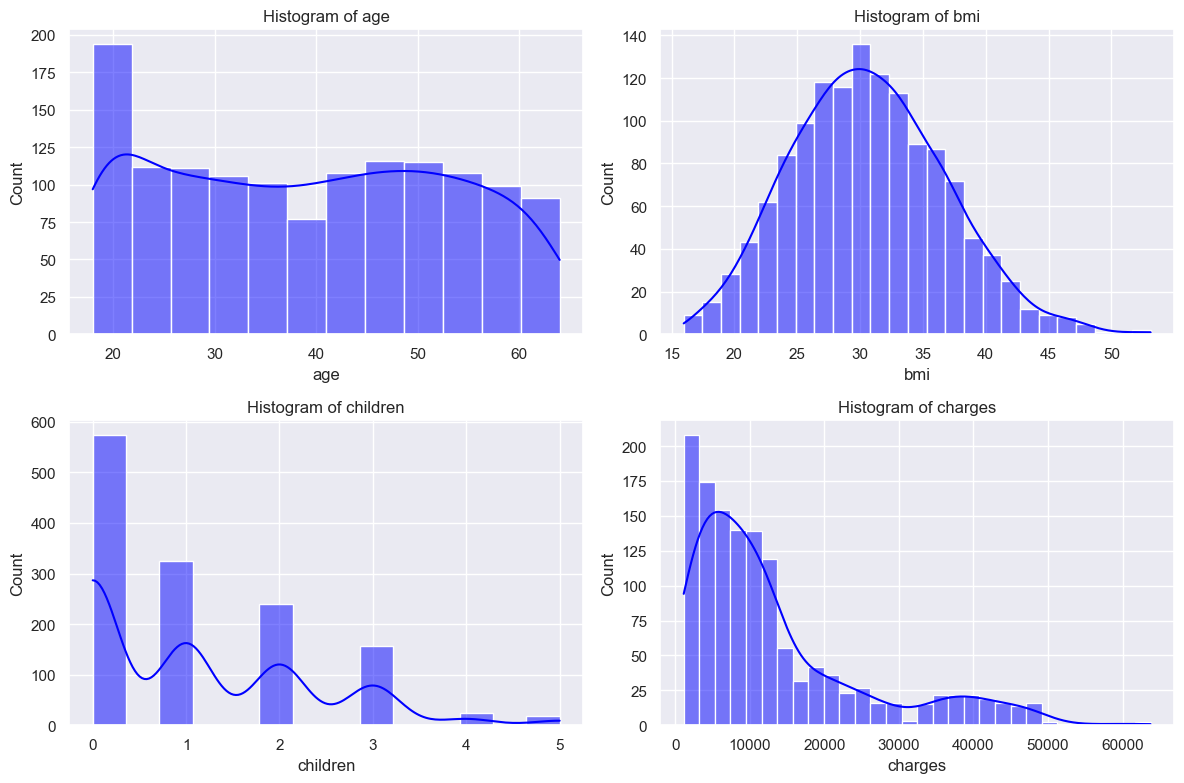

In [77]:
print(df.info())
print(df.describe())

df = df.dropna()

numeric_df = df.select_dtypes(include=[np.number])
numeric_cols = numeric_df.columns

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, kde=True, color='blue')
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

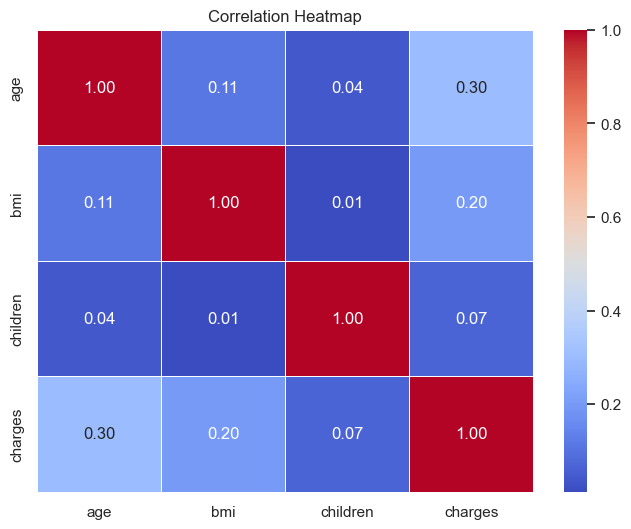

In [78]:
# Plot heatmap
corr_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

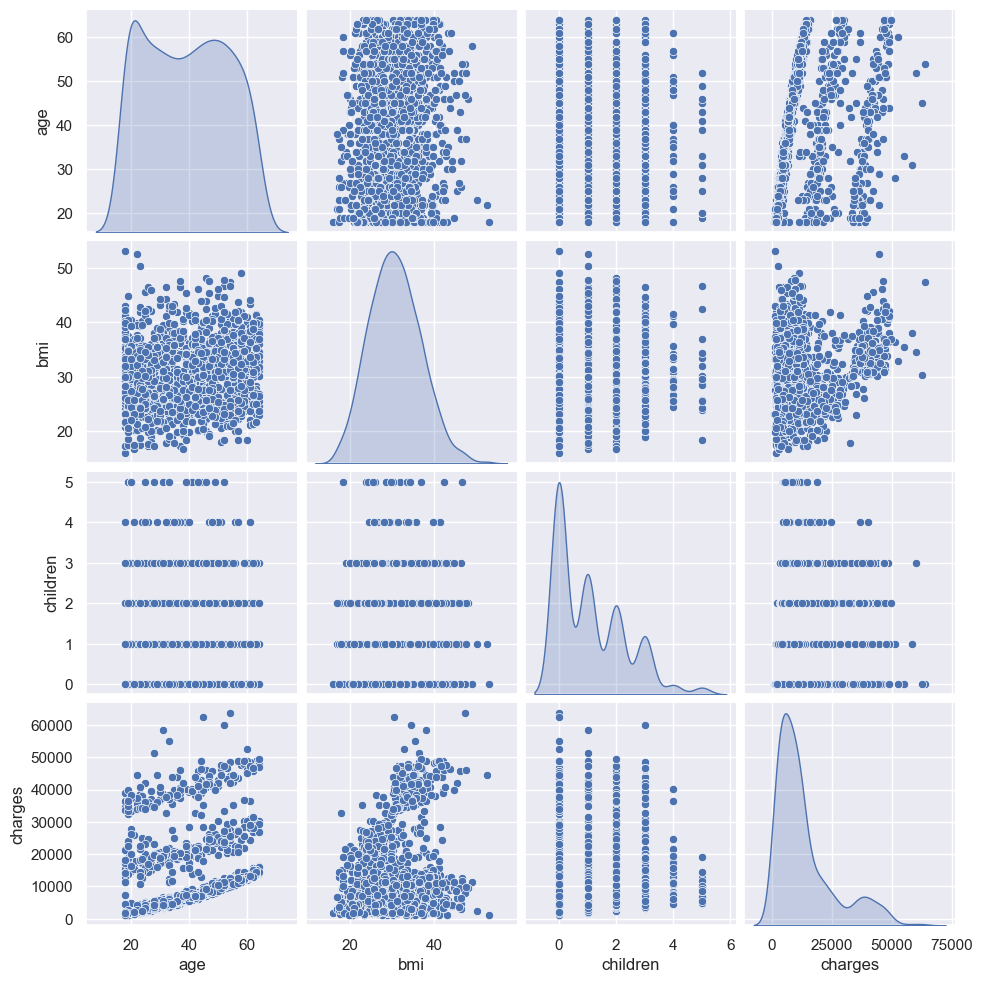

In [79]:
sns.pairplot(df, diag_kind="kde")
plt.show()

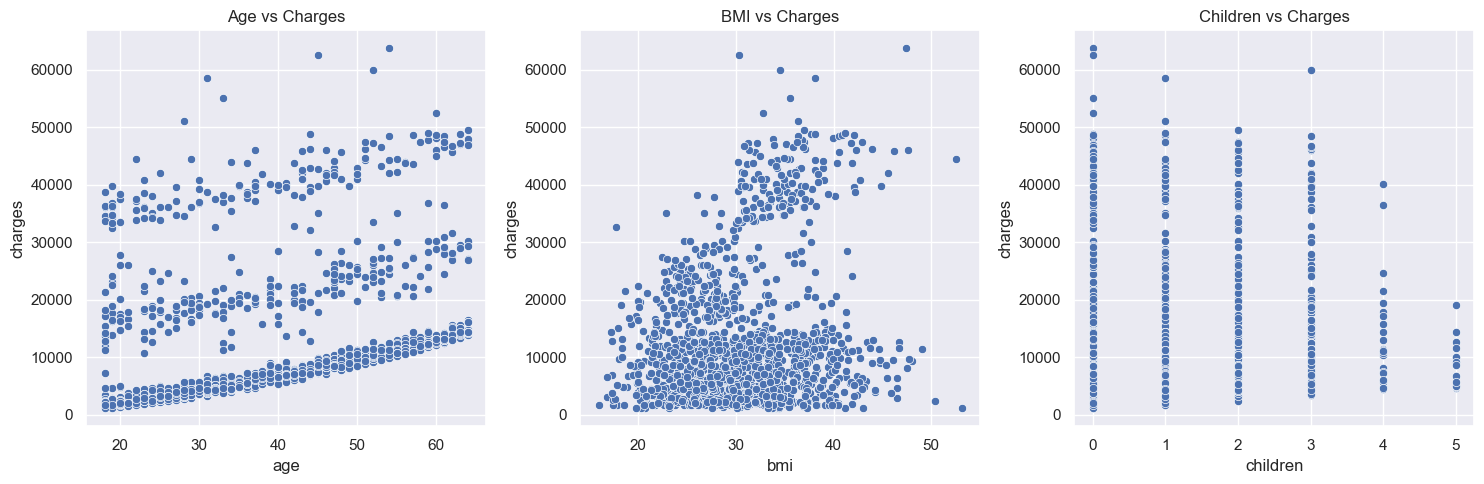

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plots for age, bmi, children vs. charges
sns.scatterplot(x=df["age"], y=df["charges"], ax=axes[0])
axes[0].set_title("Age vs Charges")

sns.scatterplot(x=df["bmi"], y=df["charges"], ax=axes[1])
axes[1].set_title("BMI vs Charges")

sns.scatterplot(x=df["children"], y=df["charges"], ax=axes[2])
axes[2].set_title("Children vs Charges")

plt.tight_layout()
plt.show()

Based on the plots, none of the numerical show a significant correlation with or any strong relationship with charges. Age had the highestest correlation value at 0.3 and the pair plots and scatter plots showed a slight trend. To verify the plots, need to determe the best predictor and best numeric predictor to maximize R_squared

In [81]:
best_predictor = ''
best_numeric_predictor=''
best_r_squared=0

for feature in numeric_cols:
    if feature != 'charges':
        model = smf.ols(formula=f'charges ~ {feature}', data=df).fit()
        
        r_squared = model.rsquared
        
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_numeric_predictor = feature

for feature in df.columns:
    if feature != 'charges':
        model = smf.ols(formula=f'charges ~ {feature}', data=df).fit()
        
        r_squared = model.rsquared
        
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_predictor = feature
            
print(best_numeric_predictor)
print(best_predictor)

age
smoker


As expected, age was the best numerical predictor of insurance cost. However, it's clear the best actual predictor is smoking status which was a categorical data and not included in the linear regression. Fitting polynomial regression up to N=10 to see the R-squared value. 

In [82]:
best_degree = 1
best_r_squared = 0

for degree in range(1, 11):
    formula = 'charges ~ ' + ' + '.join([f'np.power({best_numeric_predictor}, {i})' for i in range(1, degree + 1)])
    
    model = smf.ols(formula=formula, data=df).fit()
    r_squared = model.rsquared
    print(f"Degree: {degree}, R-squared: {r_squared}")
    
    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_degree = degree
        
print(best_degree)
print(best_r_squared)

Degree: 1, R-squared: 0.08940589967885781
Degree: 2, R-squared: 0.09059354818621057
Degree: 3, R-squared: 0.09097746408882068
Degree: 4, R-squared: 0.09131044965439195
Degree: 5, R-squared: 0.09249196059985831
Degree: 6, R-squared: 0.09252734616975877
Degree: 7, R-squared: 0.09255909833452824
Degree: 8, R-squared: 0.09262137312557361
Degree: 9, R-squared: 0.0926650602743414
Degree: 10, R-squared: 0.09259454427988523
9
0.0926650602743414


# Predictive Modeling 

The R_squared value using polynomial regression is incredibly low and the best predictor happened to be a cateogorical value anyways. Trying Decision Tree / Random Forest model instead to account for categorical data.

The use categorical data, preprocessing by encoding is required.

In [83]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['sex', 'region'], drop_first=True)

# Encode 'smoker' as binary
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

# Define features (X) and target (y)
X = df.drop(columns=['charges'])  # Features
y = df['charges']  # Target variable (insurance cost)

# Split data into train/test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree Regression

In [92]:
# Train a Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)
print(f'Decision Tree R2 Score: {r2}')
print(f'Decision Tree MSE: {mse_dt}')

R2 Score: 0.8336098314514941
Decision Tree MSE: 25831862.59985791


Random Forest Regression

In [96]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
print(f'Random Forest R2 Score: {r2}')
print(f'Random Forest MSE: {mse_rf}')

Random Forest R2 Score: 0.8639195951397501
Random Forest MSE: 21126310.23544076


# Feature Importance Analysis

The R-squared value is much better for both decision tree / random forest than polynomial regression done above. Random Forest Regressio has slightly better R-square value than Decision Tree so I will be applying hyperparameter tuning on random forest. The plot below should help visualize the importance of each feature in the model. As expected, smoker status ( which was a categorical data ) is by far the most important in the random forest model. However, bmi is more important than age from numerical categories which contradicts the best predictor value from the linear regression model. 

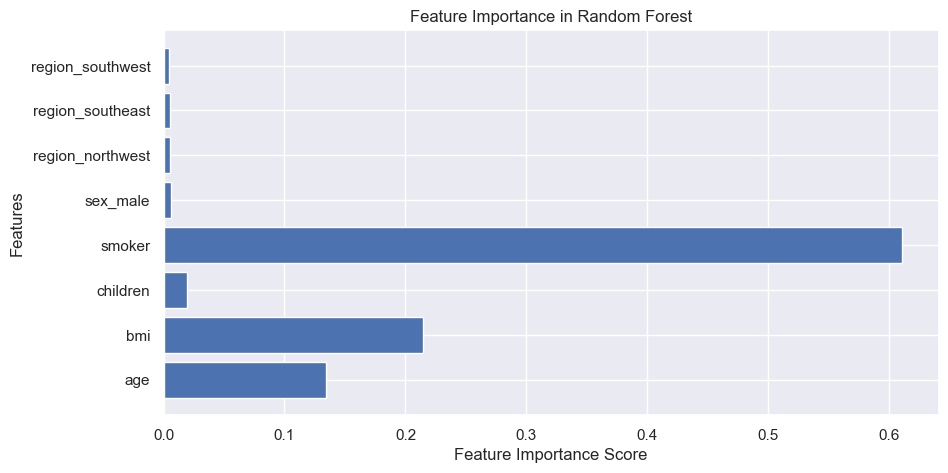

In [97]:
# Get feature importance
feature_importances = rf_model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 5))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

Hyperparameter tuning

In [90]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}


Improved Random Forest Regression Model

In [94]:
# Train a Random Forest Regressor with values from hyperparameter tuning
rf_model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
print(f'Random Forest R2 Score: {r2}')
print(f'Random Forest MSE: {mse_rf}')

R2 Score: 0.8666287873624188
Random Forest MSE: 20705711.57950407
